In [1]:
import cv2
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np
import pandas as pd
from glob import glob
import random
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import torchvision.models as models
from torchvision import transforms

In [2]:
import cv2
import keras

Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/competition/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ubuntu/anaconda3/envs/competition/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ubuntu/anaconda3/envs/competition/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home

In [3]:
keras.__version__

'2.2.0'

In [4]:
#helper function for data visualization

## 이미지 출력하는 함수

def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x

In [5]:
class Dataset:
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['background', 'tree']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, #[리스트]
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.ids2 = os.listdir(masks_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids2]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
       # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

In [6]:
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)   

In [7]:
def get_data(data_dir):
    # get image path
    img_path = os.listdir(data_dir)
    try :
        img_path.remove('.ipynb_checkpoints')
    except:
        pass
    img_path_list = [os.path.join(data_dir, x) for x in img_path]
    img_path_list = sorted(img_path_list)
    return img_path_list

In [8]:
import albumentations as A

def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation():
    train_transform = [
        A.Resize(320, 320), 
        A.HorizontalFlip(p=0.5),

        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        # A.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        A.RandomCrop(height=128, width=128, always_apply=True),

        A.IAAAdditiveGaussianNoise(p=0.2),
        A.IAAPerspective(p=0.5),

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.IAASharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.Resize(320, 320)
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

### Data Load

In [9]:
##### 경로 설정 ######

DATA_DIR = './data/segmentation'

x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'trainannot')

x_valid_dir = os.path.join(DATA_DIR, 'valid')
y_valid_dir = os.path.join(DATA_DIR, 'validannot')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'testannot')


### data load
x_train_img = get_data(x_train_dir)
y_train_img = get_data(y_train_dir)

x_valid_img = get_data(x_valid_dir)
y_valid_img = get_data(y_valid_dir)

### 이미지 출력 확인

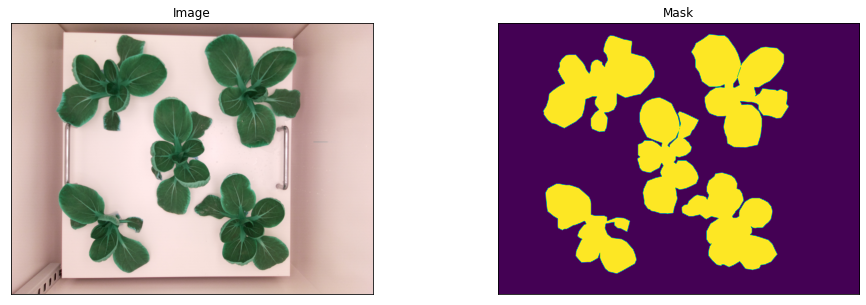

In [10]:
%matplotlib inline
from matplotlib import pyplot as plt

dataset = Dataset(x_train_dir, y_train_dir, classes=['tree'])
image, mask = dataset[1]

visualize(
    image=image, 
    mask=mask[..., 0].squeeze()
)

### DataSet(augmentation....) 확인

/home/ubuntu/anaconda3/envs/competition/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:2029: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  warnings.warn('Using lambda is incompatible with multiprocessing. '


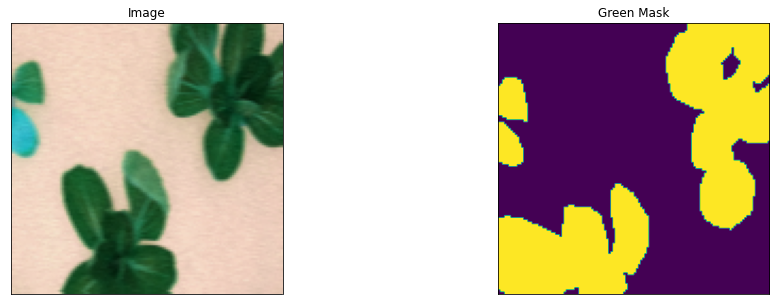

In [11]:
# Lets look at augmented data we have
dataset = Dataset(x_valid_dir, 
                  y_valid_dir, 
                  classes=['tree'], 
                  augmentation=get_training_augmentation())

image, mask = dataset[1] # get some sample
visualize(
    image=image, 
    green_mask=mask[..., 0].squeeze(),
)

# Image Segmentation

In [12]:
import segmentation_models as sm

Segmentation Models: using `keras` framework.


In [13]:
BACKBONE = 'efficientnetb3'
BATCH_SIZE = 10
CLASSES = ['tree']
LR = 0.0001
EPOCHS = 40

preprocess_input = sm.get_preprocessing(BACKBONE)

In [15]:
# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

In [ ]:
#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)

2022-05-03 11:33:14.105351: E tensorflow/stream_executor/cuda/cuda_driver.cc:806] failed to allocate 8.22M (8615424 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-05-03 11:33:14.106488: E tensorflow/stream_executor/cuda/cuda_driver.cc:806] failed to allocate 8.22M (8615424 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-05-03 11:33:24.107629: E tensorflow/stream_executor/cuda/cuda_driver.cc:806] failed to allocate 8.22M (8615424 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-05-03 11:33:24.108734: E tensorflow/stream_executor/cuda/cuda_driver.cc:806] failed to allocate 8.22M (8615424 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-05-03 11:33:24.108763: W tensorflow/core/common_runtime/bfc_allocator.cc:267] Allocator (GPU_0_bfc) ran out of memory trying to allocate 433.5KiB.  Current allocation summary follows.
2022-05-03 11:33:24.108787: I tensorflow/core/common_runtime/bfc_allocator.cc:597] Bin (256): 	Total Chunks

2022-05-03 11:33:34.118169: E tensorflow/stream_executor/cuda/cuda_driver.cc:806] failed to allocate 8.22M (8615424 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-05-03 11:33:34.119277: E tensorflow/stream_executor/cuda/cuda_driver.cc:806] failed to allocate 8.22M (8615424 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-05-03 11:33:34.119305: W tensorflow/core/common_runtime/bfc_allocator.cc:267] Allocator (GPU_0_bfc) ran out of memory trying to allocate 433.5KiB.  Current allocation summary follows.
2022-05-03 11:33:34.119327: I tensorflow/core/common_runtime/bfc_allocator.cc:597] Bin (256): 	Total Chunks: 468, Chunks in use: 468. 117.0KiB allocated for chunks. 117.0KiB in use in bin. 11.3KiB client-requested in use in bin.
2022-05-03 11:33:34.119339: I tensorflow/core/common_runtime/bfc_allocator.cc:597] Bin (512): 	Total Chunks: 92, Chunks in use: 92. 63.5KiB allocated for chunks. 63.5KiB in use in bin. 51.4KiB client-requested in use in bin.
2022-

2022-05-03 11:33:44.128830: E tensorflow/stream_executor/cuda/cuda_driver.cc:806] failed to allocate 8.22M (8615424 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-05-03 11:33:44.129953: E tensorflow/stream_executor/cuda/cuda_driver.cc:806] failed to allocate 8.22M (8615424 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-05-03 11:33:44.129980: W tensorflow/core/common_runtime/bfc_allocator.cc:267] Allocator (GPU_0_bfc) ran out of memory trying to allocate 433.5KiB.  Current allocation summary follows.
2022-05-03 11:33:44.130003: I tensorflow/core/common_runtime/bfc_allocator.cc:597] Bin (256): 	Total Chunks: 468, Chunks in use: 468. 117.0KiB allocated for chunks. 117.0KiB in use in bin. 11.3KiB client-requested in use in bin.
2022-05-03 11:33:44.130013: I tensorflow/core/common_runtime/bfc_allocator.cc:597] Bin (512): 	Total Chunks: 92, Chunks in use: 92. 63.5KiB allocated for chunks. 63.5KiB in use in bin. 51.4KiB client-requested in use in bin.
2022-

2022-05-03 11:33:54.139418: E tensorflow/stream_executor/cuda/cuda_driver.cc:806] failed to allocate 8.22M (8615424 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-05-03 11:33:54.140502: E tensorflow/stream_executor/cuda/cuda_driver.cc:806] failed to allocate 8.22M (8615424 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-05-03 11:33:54.140530: W tensorflow/core/common_runtime/bfc_allocator.cc:267] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4B.  Current allocation summary follows.
2022-05-03 11:33:54.140558: I tensorflow/core/common_runtime/bfc_allocator.cc:597] Bin (256): 	Total Chunks: 468, Chunks in use: 468. 117.0KiB allocated for chunks. 117.0KiB in use in bin. 11.3KiB client-requested in use in bin.
2022-05-03 11:33:54.140568: I tensorflow/core/common_runtime/bfc_allocator.cc:597] Bin (512): 	Total Chunks: 92, Chunks in use: 92. 63.5KiB allocated for chunks. 63.5KiB in use in bin. 51.4KiB client-requested in use in bin.
2022-05-03 

2022-05-03 11:34:04.152436: E tensorflow/stream_executor/cuda/cuda_driver.cc:806] failed to allocate 8.22M (8615424 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-05-03 11:34:04.153557: E tensorflow/stream_executor/cuda/cuda_driver.cc:806] failed to allocate 8.22M (8615424 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-05-03 11:34:04.153585: W tensorflow/core/common_runtime/bfc_allocator.cc:267] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.2KiB.  Current allocation summary follows.
2022-05-03 11:34:04.153609: I tensorflow/core/common_runtime/bfc_allocator.cc:597] Bin (256): 	Total Chunks: 468, Chunks in use: 468. 117.0KiB allocated for chunks. 117.0KiB in use in bin. 11.3KiB client-requested in use in bin.
2022-05-03 11:34:04.153619: I tensorflow/core/common_runtime/bfc_allocator.cc:597] Bin (512): 	Total Chunks: 92, Chunks in use: 92. 63.5KiB allocated for chunks. 63.5KiB in use in bin. 51.4KiB client-requested in use in bin.
2022-05

2022-05-03 11:34:14.162982: E tensorflow/stream_executor/cuda/cuda_driver.cc:806] failed to allocate 8.22M (8615424 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-05-03 11:34:14.164085: E tensorflow/stream_executor/cuda/cuda_driver.cc:806] failed to allocate 8.22M (8615424 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-05-03 11:34:14.164114: W tensorflow/core/common_runtime/bfc_allocator.cc:267] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.2KiB.  Current allocation summary follows.
2022-05-03 11:34:14.164137: I tensorflow/core/common_runtime/bfc_allocator.cc:597] Bin (256): 	Total Chunks: 468, Chunks in use: 468. 117.0KiB allocated for chunks. 117.0KiB in use in bin. 11.3KiB client-requested in use in bin.
2022-05-03 11:34:14.164148: I tensorflow/core/common_runtime/bfc_allocator.cc:597] Bin (512): 	Total Chunks: 92, Chunks in use: 92. 63.5KiB allocated for chunks. 63.5KiB in use in bin. 51.4KiB client-requested in use in bin.
2022-05

2022-05-03 11:34:24.173557: E tensorflow/stream_executor/cuda/cuda_driver.cc:806] failed to allocate 8.22M (8615424 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-05-03 11:34:24.174690: E tensorflow/stream_executor/cuda/cuda_driver.cc:806] failed to allocate 8.22M (8615424 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-05-03 11:34:24.174716: W tensorflow/core/common_runtime/bfc_allocator.cc:267] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.2KiB.  Current allocation summary follows.
2022-05-03 11:34:24.174737: I tensorflow/core/common_runtime/bfc_allocator.cc:597] Bin (256): 	Total Chunks: 468, Chunks in use: 468. 117.0KiB allocated for chunks. 117.0KiB in use in bin. 11.3KiB client-requested in use in bin.
2022-05-03 11:34:24.174748: I tensorflow/core/common_runtime/bfc_allocator.cc:597] Bin (512): 	Total Chunks: 92, Chunks in use: 92. 63.5KiB allocated for chunks. 63.5KiB in use in bin. 51.4KiB client-requested in use in bin.
2022-05

2022-05-03 11:34:34.184086: E tensorflow/stream_executor/cuda/cuda_driver.cc:806] failed to allocate 8.22M (8615424 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-05-03 11:34:34.185201: E tensorflow/stream_executor/cuda/cuda_driver.cc:806] failed to allocate 8.22M (8615424 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-05-03 11:34:34.185228: W tensorflow/core/common_runtime/bfc_allocator.cc:267] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.2KiB.  Current allocation summary follows.
2022-05-03 11:34:34.185250: I tensorflow/core/common_runtime/bfc_allocator.cc:597] Bin (256): 	Total Chunks: 468, Chunks in use: 468. 117.0KiB allocated for chunks. 117.0KiB in use in bin. 11.3KiB client-requested in use in bin.
2022-05-03 11:34:34.185260: I tensorflow/core/common_runtime/bfc_allocator.cc:597] Bin (512): 	Total Chunks: 92, Chunks in use: 92. 63.5KiB allocated for chunks. 63.5KiB in use in bin. 51.4KiB client-requested in use in bin.
2022-05

2022-05-03 11:34:44.194629: E tensorflow/stream_executor/cuda/cuda_driver.cc:806] failed to allocate 8.22M (8615424 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-05-03 11:34:44.195727: E tensorflow/stream_executor/cuda/cuda_driver.cc:806] failed to allocate 8.22M (8615424 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-05-03 11:34:44.195754: W tensorflow/core/common_runtime/bfc_allocator.cc:267] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.2KiB.  Current allocation summary follows.
2022-05-03 11:34:44.195776: I tensorflow/core/common_runtime/bfc_allocator.cc:597] Bin (256): 	Total Chunks: 468, Chunks in use: 468. 117.0KiB allocated for chunks. 117.0KiB in use in bin. 11.3KiB client-requested in use in bin.
2022-05-03 11:34:44.195786: I tensorflow/core/common_runtime/bfc_allocator.cc:597] Bin (512): 	Total Chunks: 92, Chunks in use: 92. 63.5KiB allocated for chunks. 63.5KiB in use in bin. 51.4KiB client-requested in use in bin.
2022-05

2022-05-03 11:34:54.205181: E tensorflow/stream_executor/cuda/cuda_driver.cc:806] failed to allocate 8.22M (8615424 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-05-03 11:34:54.206304: E tensorflow/stream_executor/cuda/cuda_driver.cc:806] failed to allocate 8.22M (8615424 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-05-03 11:34:54.206331: W tensorflow/core/common_runtime/bfc_allocator.cc:267] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.2KiB.  Current allocation summary follows.
2022-05-03 11:34:54.206354: I tensorflow/core/common_runtime/bfc_allocator.cc:597] Bin (256): 	Total Chunks: 468, Chunks in use: 468. 117.0KiB allocated for chunks. 117.0KiB in use in bin. 11.3KiB client-requested in use in bin.
2022-05-03 11:34:54.206364: I tensorflow/core/common_runtime/bfc_allocator.cc:597] Bin (512): 	Total Chunks: 92, Chunks in use: 92. 63.5KiB allocated for chunks. 63.5KiB in use in bin. 51.4KiB client-requested in use in bin.
2022-05

2022-05-03 11:35:04.215764: E tensorflow/stream_executor/cuda/cuda_driver.cc:806] failed to allocate 8.22M (8615424 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-05-03 11:35:04.216805: E tensorflow/stream_executor/cuda/cuda_driver.cc:806] failed to allocate 8.22M (8615424 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-05-03 11:35:04.216831: W tensorflow/core/common_runtime/bfc_allocator.cc:267] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.2KiB.  Current allocation summary follows.
2022-05-03 11:35:04.216860: I tensorflow/core/common_runtime/bfc_allocator.cc:597] Bin (256): 	Total Chunks: 468, Chunks in use: 468. 117.0KiB allocated for chunks. 117.0KiB in use in bin. 11.3KiB client-requested in use in bin.
2022-05-03 11:35:04.216871: I tensorflow/core/common_runtime/bfc_allocator.cc:597] Bin (512): 	Total Chunks: 92, Chunks in use: 92. 63.5KiB allocated for chunks. 63.5KiB in use in bin. 51.4KiB client-requested in use in bin.
2022-05

2022-05-03 11:35:14.225429: E tensorflow/stream_executor/cuda/cuda_driver.cc:806] failed to allocate 8.22M (8615424 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-05-03 11:35:14.226453: E tensorflow/stream_executor/cuda/cuda_driver.cc:806] failed to allocate 8.22M (8615424 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-05-03 11:35:14.226475: W tensorflow/core/common_runtime/bfc_allocator.cc:267] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.2KiB.  Current allocation summary follows.
2022-05-03 11:35:14.226502: I tensorflow/core/common_runtime/bfc_allocator.cc:597] Bin (256): 	Total Chunks: 468, Chunks in use: 468. 117.0KiB allocated for chunks. 117.0KiB in use in bin. 11.3KiB client-requested in use in bin.
2022-05-03 11:35:14.226512: I tensorflow/core/common_runtime/bfc_allocator.cc:597] Bin (512): 	Total Chunks: 92, Chunks in use: 92. 63.5KiB allocated for chunks. 63.5KiB in use in bin. 51.4KiB client-requested in use in bin.
2022-05

2022-05-03 11:35:24.234899: E tensorflow/stream_executor/cuda/cuda_driver.cc:806] failed to allocate 8.22M (8615424 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-05-03 11:35:24.235907: E tensorflow/stream_executor/cuda/cuda_driver.cc:806] failed to allocate 8.22M (8615424 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-05-03 11:35:24.235930: W tensorflow/core/common_runtime/bfc_allocator.cc:267] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.2KiB.  Current allocation summary follows.
2022-05-03 11:35:24.235955: I tensorflow/core/common_runtime/bfc_allocator.cc:597] Bin (256): 	Total Chunks: 468, Chunks in use: 468. 117.0KiB allocated for chunks. 117.0KiB in use in bin. 11.3KiB client-requested in use in bin.
2022-05-03 11:35:24.235965: I tensorflow/core/common_runtime/bfc_allocator.cc:597] Bin (512): 	Total Chunks: 92, Chunks in use: 92. 63.5KiB allocated for chunks. 63.5KiB in use in bin. 51.4KiB client-requested in use in bin.
2022-05

2022-05-03 11:35:34.244519: E tensorflow/stream_executor/cuda/cuda_driver.cc:806] failed to allocate 8.22M (8615424 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-05-03 11:35:34.245608: E tensorflow/stream_executor/cuda/cuda_driver.cc:806] failed to allocate 8.22M (8615424 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-05-03 11:35:34.245634: W tensorflow/core/common_runtime/bfc_allocator.cc:267] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.2KiB.  Current allocation summary follows.
2022-05-03 11:35:34.245662: I tensorflow/core/common_runtime/bfc_allocator.cc:597] Bin (256): 	Total Chunks: 468, Chunks in use: 468. 117.0KiB allocated for chunks. 117.0KiB in use in bin. 11.3KiB client-requested in use in bin.
2022-05-03 11:35:34.245672: I tensorflow/core/common_runtime/bfc_allocator.cc:597] Bin (512): 	Total Chunks: 92, Chunks in use: 92. 63.5KiB allocated for chunks. 63.5KiB in use in bin. 51.4KiB client-requested in use in bin.
2022-05

2022-05-03 11:35:44.255818: E tensorflow/stream_executor/cuda/cuda_driver.cc:806] failed to allocate 8.22M (8615424 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-05-03 11:35:44.256820: E tensorflow/stream_executor/cuda/cuda_driver.cc:806] failed to allocate 8.22M (8615424 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-05-03 11:35:44.256842: W tensorflow/core/common_runtime/bfc_allocator.cc:267] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.2KiB.  Current allocation summary follows.
2022-05-03 11:35:44.256864: I tensorflow/core/common_runtime/bfc_allocator.cc:597] Bin (256): 	Total Chunks: 468, Chunks in use: 468. 117.0KiB allocated for chunks. 117.0KiB in use in bin. 11.3KiB client-requested in use in bin.
2022-05-03 11:35:44.256871: I tensorflow/core/common_runtime/bfc_allocator.cc:597] Bin (512): 	Total Chunks: 92, Chunks in use: 92. 63.5KiB allocated for chunks. 63.5KiB in use in bin. 51.4KiB client-requested in use in bin.
2022-05

2022-05-03 11:35:54.265924: E tensorflow/stream_executor/cuda/cuda_driver.cc:806] failed to allocate 8.22M (8615424 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-05-03 11:35:54.267007: E tensorflow/stream_executor/cuda/cuda_driver.cc:806] failed to allocate 8.22M (8615424 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-05-03 11:35:54.267035: W tensorflow/core/common_runtime/bfc_allocator.cc:267] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.2KiB.  Current allocation summary follows.
2022-05-03 11:35:54.267061: I tensorflow/core/common_runtime/bfc_allocator.cc:597] Bin (256): 	Total Chunks: 468, Chunks in use: 468. 117.0KiB allocated for chunks. 117.0KiB in use in bin. 11.3KiB client-requested in use in bin.
2022-05-03 11:35:54.267072: I tensorflow/core/common_runtime/bfc_allocator.cc:597] Bin (512): 	Total Chunks: 92, Chunks in use: 92. 63.5KiB allocated for chunks. 63.5KiB in use in bin. 51.4KiB client-requested in use in bin.
2022-05

2022-05-03 11:36:04.277411: E tensorflow/stream_executor/cuda/cuda_driver.cc:806] failed to allocate 8.22M (8615424 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-05-03 11:36:04.278435: E tensorflow/stream_executor/cuda/cuda_driver.cc:806] failed to allocate 8.22M (8615424 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-05-03 11:36:04.278457: W tensorflow/core/common_runtime/bfc_allocator.cc:267] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.2KiB.  Current allocation summary follows.
2022-05-03 11:36:04.278479: I tensorflow/core/common_runtime/bfc_allocator.cc:597] Bin (256): 	Total Chunks: 468, Chunks in use: 468. 117.0KiB allocated for chunks. 117.0KiB in use in bin. 11.3KiB client-requested in use in bin.
2022-05-03 11:36:04.278486: I tensorflow/core/common_runtime/bfc_allocator.cc:597] Bin (512): 	Total Chunks: 92, Chunks in use: 92. 63.5KiB allocated for chunks. 63.5KiB in use in bin. 51.4KiB client-requested in use in bin.
2022-05

2022-05-03 11:36:14.287334: E tensorflow/stream_executor/cuda/cuda_driver.cc:806] failed to allocate 8.22M (8615424 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-05-03 11:36:14.288325: E tensorflow/stream_executor/cuda/cuda_driver.cc:806] failed to allocate 8.22M (8615424 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-05-03 11:36:14.288347: W tensorflow/core/common_runtime/bfc_allocator.cc:267] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.2KiB.  Current allocation summary follows.
2022-05-03 11:36:14.288373: I tensorflow/core/common_runtime/bfc_allocator.cc:597] Bin (256): 	Total Chunks: 468, Chunks in use: 468. 117.0KiB allocated for chunks. 117.0KiB in use in bin. 11.3KiB client-requested in use in bin.
2022-05-03 11:36:14.288382: I tensorflow/core/common_runtime/bfc_allocator.cc:597] Bin (512): 	Total Chunks: 92, Chunks in use: 92. 63.5KiB allocated for chunks. 63.5KiB in use in bin. 51.4KiB client-requested in use in bin.
2022-05

2022-05-03 11:36:24.297121: E tensorflow/stream_executor/cuda/cuda_driver.cc:806] failed to allocate 8.22M (8615424 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-05-03 11:36:24.298217: E tensorflow/stream_executor/cuda/cuda_driver.cc:806] failed to allocate 8.22M (8615424 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-05-03 11:36:24.298244: W tensorflow/core/common_runtime/bfc_allocator.cc:267] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.2KiB.  Current allocation summary follows.
2022-05-03 11:36:24.298271: I tensorflow/core/common_runtime/bfc_allocator.cc:597] Bin (256): 	Total Chunks: 468, Chunks in use: 468. 117.0KiB allocated for chunks. 117.0KiB in use in bin. 11.3KiB client-requested in use in bin.
2022-05-03 11:36:24.298282: I tensorflow/core/common_runtime/bfc_allocator.cc:597] Bin (512): 	Total Chunks: 92, Chunks in use: 92. 63.5KiB allocated for chunks. 63.5KiB in use in bin. 51.4KiB client-requested in use in bin.
2022-05

2022-05-03 11:36:34.307052: E tensorflow/stream_executor/cuda/cuda_driver.cc:806] failed to allocate 8.22M (8615424 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-05-03 11:36:34.308106: E tensorflow/stream_executor/cuda/cuda_driver.cc:806] failed to allocate 8.22M (8615424 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-05-03 11:36:34.308131: W tensorflow/core/common_runtime/bfc_allocator.cc:267] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.2KiB.  Current allocation summary follows.
2022-05-03 11:36:34.308153: I tensorflow/core/common_runtime/bfc_allocator.cc:597] Bin (256): 	Total Chunks: 468, Chunks in use: 468. 117.0KiB allocated for chunks. 117.0KiB in use in bin. 11.3KiB client-requested in use in bin.
2022-05-03 11:36:34.308161: I tensorflow/core/common_runtime/bfc_allocator.cc:597] Bin (512): 	Total Chunks: 92, Chunks in use: 92. 63.5KiB allocated for chunks. 63.5KiB in use in bin. 51.4KiB client-requested in use in bin.
2022-05

2022-05-03 11:36:44.318088: E tensorflow/stream_executor/cuda/cuda_driver.cc:806] failed to allocate 8.22M (8615424 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-05-03 11:36:44.319187: E tensorflow/stream_executor/cuda/cuda_driver.cc:806] failed to allocate 8.22M (8615424 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-05-03 11:36:44.319217: W tensorflow/core/common_runtime/bfc_allocator.cc:267] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.2KiB.  Current allocation summary follows.
2022-05-03 11:36:44.319239: I tensorflow/core/common_runtime/bfc_allocator.cc:597] Bin (256): 	Total Chunks: 468, Chunks in use: 468. 117.0KiB allocated for chunks. 117.0KiB in use in bin. 11.3KiB client-requested in use in bin.
2022-05-03 11:36:44.319250: I tensorflow/core/common_runtime/bfc_allocator.cc:597] Bin (512): 	Total Chunks: 92, Chunks in use: 92. 63.5KiB allocated for chunks. 63.5KiB in use in bin. 51.4KiB client-requested in use in bin.
2022-05

2022-05-03 11:36:54.329025: E tensorflow/stream_executor/cuda/cuda_driver.cc:806] failed to allocate 8.22M (8615424 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-05-03 11:36:54.330160: E tensorflow/stream_executor/cuda/cuda_driver.cc:806] failed to allocate 8.22M (8615424 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-05-03 11:36:54.330187: W tensorflow/core/common_runtime/bfc_allocator.cc:267] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.2KiB.  Current allocation summary follows.
2022-05-03 11:36:54.330209: I tensorflow/core/common_runtime/bfc_allocator.cc:597] Bin (256): 	Total Chunks: 468, Chunks in use: 468. 117.0KiB allocated for chunks. 117.0KiB in use in bin. 11.3KiB client-requested in use in bin.
2022-05-03 11:36:54.330219: I tensorflow/core/common_runtime/bfc_allocator.cc:597] Bin (512): 	Total Chunks: 92, Chunks in use: 92. 63.5KiB allocated for chunks. 63.5KiB in use in bin. 51.4KiB client-requested in use in bin.
2022-05

2022-05-03 11:37:04.339287: E tensorflow/stream_executor/cuda/cuda_driver.cc:806] failed to allocate 8.22M (8615424 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-05-03 11:37:04.340293: E tensorflow/stream_executor/cuda/cuda_driver.cc:806] failed to allocate 8.22M (8615424 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-05-03 11:37:04.340315: W tensorflow/core/common_runtime/bfc_allocator.cc:267] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.2KiB.  Current allocation summary follows.
2022-05-03 11:37:04.340341: I tensorflow/core/common_runtime/bfc_allocator.cc:597] Bin (256): 	Total Chunks: 468, Chunks in use: 468. 117.0KiB allocated for chunks. 117.0KiB in use in bin. 11.3KiB client-requested in use in bin.
2022-05-03 11:37:04.340350: I tensorflow/core/common_runtime/bfc_allocator.cc:597] Bin (512): 	Total Chunks: 92, Chunks in use: 92. 63.5KiB allocated for chunks. 63.5KiB in use in bin. 51.4KiB client-requested in use in bin.
2022-05

2022-05-03 11:37:14.349170: E tensorflow/stream_executor/cuda/cuda_driver.cc:806] failed to allocate 8.22M (8615424 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-05-03 11:37:14.350187: E tensorflow/stream_executor/cuda/cuda_driver.cc:806] failed to allocate 8.22M (8615424 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-05-03 11:37:14.350208: W tensorflow/core/common_runtime/bfc_allocator.cc:267] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.2KiB.  Current allocation summary follows.
2022-05-03 11:37:14.350235: I tensorflow/core/common_runtime/bfc_allocator.cc:597] Bin (256): 	Total Chunks: 468, Chunks in use: 468. 117.0KiB allocated for chunks. 117.0KiB in use in bin. 11.3KiB client-requested in use in bin.
2022-05-03 11:37:14.350244: I tensorflow/core/common_runtime/bfc_allocator.cc:597] Bin (512): 	Total Chunks: 92, Chunks in use: 92. 63.5KiB allocated for chunks. 63.5KiB in use in bin. 51.4KiB client-requested in use in bin.
2022-05

2022-05-03 11:37:24.358752: E tensorflow/stream_executor/cuda/cuda_driver.cc:806] failed to allocate 8.22M (8615424 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-05-03 11:37:24.359727: E tensorflow/stream_executor/cuda/cuda_driver.cc:806] failed to allocate 8.22M (8615424 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-05-03 11:37:24.359745: W tensorflow/core/common_runtime/bfc_allocator.cc:267] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.2KiB.  Current allocation summary follows.
2022-05-03 11:37:24.359767: I tensorflow/core/common_runtime/bfc_allocator.cc:597] Bin (256): 	Total Chunks: 468, Chunks in use: 468. 117.0KiB allocated for chunks. 117.0KiB in use in bin. 11.3KiB client-requested in use in bin.
2022-05-03 11:37:24.359774: I tensorflow/core/common_runtime/bfc_allocator.cc:597] Bin (512): 	Total Chunks: 92, Chunks in use: 92. 63.5KiB allocated for chunks. 63.5KiB in use in bin. 51.4KiB client-requested in use in bin.
2022-05

2022-05-03 11:37:34.368717: E tensorflow/stream_executor/cuda/cuda_driver.cc:806] failed to allocate 8.22M (8615424 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-05-03 11:37:34.369806: E tensorflow/stream_executor/cuda/cuda_driver.cc:806] failed to allocate 8.22M (8615424 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-05-03 11:37:34.369847: W tensorflow/core/common_runtime/bfc_allocator.cc:267] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.2KiB.  Current allocation summary follows.
2022-05-03 11:37:34.369874: I tensorflow/core/common_runtime/bfc_allocator.cc:597] Bin (256): 	Total Chunks: 468, Chunks in use: 468. 117.0KiB allocated for chunks. 117.0KiB in use in bin. 11.3KiB client-requested in use in bin.
2022-05-03 11:37:34.369885: I tensorflow/core/common_runtime/bfc_allocator.cc:597] Bin (512): 	Total Chunks: 92, Chunks in use: 92. 63.5KiB allocated for chunks. 63.5KiB in use in bin. 51.4KiB client-requested in use in bin.
2022-05

2022-05-03 11:37:44.379138: E tensorflow/stream_executor/cuda/cuda_driver.cc:806] failed to allocate 8.22M (8615424 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-05-03 11:37:44.380234: E tensorflow/stream_executor/cuda/cuda_driver.cc:806] failed to allocate 8.22M (8615424 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-05-03 11:37:44.380262: W tensorflow/core/common_runtime/bfc_allocator.cc:267] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.2KiB.  Current allocation summary follows.
2022-05-03 11:37:44.380284: I tensorflow/core/common_runtime/bfc_allocator.cc:597] Bin (256): 	Total Chunks: 468, Chunks in use: 468. 117.0KiB allocated for chunks. 117.0KiB in use in bin. 11.3KiB client-requested in use in bin.
2022-05-03 11:37:44.380295: I tensorflow/core/common_runtime/bfc_allocator.cc:597] Bin (512): 	Total Chunks: 92, Chunks in use: 92. 63.5KiB allocated for chunks. 63.5KiB in use in bin. 51.4KiB client-requested in use in bin.
2022-05

2022-05-03 11:37:54.389722: E tensorflow/stream_executor/cuda/cuda_driver.cc:806] failed to allocate 8.22M (8615424 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-05-03 11:37:54.390840: E tensorflow/stream_executor/cuda/cuda_driver.cc:806] failed to allocate 8.22M (8615424 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-05-03 11:37:54.390870: W tensorflow/core/common_runtime/bfc_allocator.cc:267] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.2KiB.  Current allocation summary follows.
2022-05-03 11:37:54.390893: I tensorflow/core/common_runtime/bfc_allocator.cc:597] Bin (256): 	Total Chunks: 468, Chunks in use: 468. 117.0KiB allocated for chunks. 117.0KiB in use in bin. 11.3KiB client-requested in use in bin.
2022-05-03 11:37:54.390903: I tensorflow/core/common_runtime/bfc_allocator.cc:597] Bin (512): 	Total Chunks: 92, Chunks in use: 92. 63.5KiB allocated for chunks. 63.5KiB in use in bin. 51.4KiB client-requested in use in bin.
2022-05

2022-05-03 11:38:04.400224: E tensorflow/stream_executor/cuda/cuda_driver.cc:806] failed to allocate 8.22M (8615424 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-05-03 11:38:04.401338: E tensorflow/stream_executor/cuda/cuda_driver.cc:806] failed to allocate 8.22M (8615424 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-05-03 11:38:04.401366: W tensorflow/core/common_runtime/bfc_allocator.cc:267] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.2KiB.  Current allocation summary follows.
2022-05-03 11:38:04.401389: I tensorflow/core/common_runtime/bfc_allocator.cc:597] Bin (256): 	Total Chunks: 468, Chunks in use: 468. 117.0KiB allocated for chunks. 117.0KiB in use in bin. 11.3KiB client-requested in use in bin.
2022-05-03 11:38:04.401401: I tensorflow/core/common_runtime/bfc_allocator.cc:597] Bin (512): 	Total Chunks: 92, Chunks in use: 92. 63.5KiB allocated for chunks. 63.5KiB in use in bin. 51.4KiB client-requested in use in bin.
2022-05

2022-05-03 11:38:14.410759: E tensorflow/stream_executor/cuda/cuda_driver.cc:806] failed to allocate 8.22M (8615424 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-05-03 11:38:14.411864: E tensorflow/stream_executor/cuda/cuda_driver.cc:806] failed to allocate 8.22M (8615424 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-05-03 11:38:14.411892: W tensorflow/core/common_runtime/bfc_allocator.cc:267] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.2KiB.  Current allocation summary follows.
2022-05-03 11:38:14.411915: I tensorflow/core/common_runtime/bfc_allocator.cc:597] Bin (256): 	Total Chunks: 468, Chunks in use: 468. 117.0KiB allocated for chunks. 117.0KiB in use in bin. 11.3KiB client-requested in use in bin.
2022-05-03 11:38:14.411925: I tensorflow/core/common_runtime/bfc_allocator.cc:597] Bin (512): 	Total Chunks: 92, Chunks in use: 92. 63.5KiB allocated for chunks. 63.5KiB in use in bin. 51.4KiB client-requested in use in bin.
2022-05

2022-05-03 11:38:24.421268: E tensorflow/stream_executor/cuda/cuda_driver.cc:806] failed to allocate 8.22M (8615424 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-05-03 11:38:24.422394: E tensorflow/stream_executor/cuda/cuda_driver.cc:806] failed to allocate 8.22M (8615424 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-05-03 11:38:24.422422: W tensorflow/core/common_runtime/bfc_allocator.cc:267] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4B.  Current allocation summary follows.
2022-05-03 11:38:24.422446: I tensorflow/core/common_runtime/bfc_allocator.cc:597] Bin (256): 	Total Chunks: 468, Chunks in use: 468. 117.0KiB allocated for chunks. 117.0KiB in use in bin. 11.3KiB client-requested in use in bin.
2022-05-03 11:38:24.422457: I tensorflow/core/common_runtime/bfc_allocator.cc:597] Bin (512): 	Total Chunks: 92, Chunks in use: 92. 63.5KiB allocated for chunks. 63.5KiB in use in bin. 51.4KiB client-requested in use in bin.
2022-05-03 

2022-05-03 11:38:34.431789: E tensorflow/stream_executor/cuda/cuda_driver.cc:806] failed to allocate 8.22M (8615424 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-05-03 11:38:34.432891: E tensorflow/stream_executor/cuda/cuda_driver.cc:806] failed to allocate 8.22M (8615424 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-05-03 11:38:34.432919: W tensorflow/core/common_runtime/bfc_allocator.cc:267] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.2KiB.  Current allocation summary follows.
2022-05-03 11:38:34.432942: I tensorflow/core/common_runtime/bfc_allocator.cc:597] Bin (256): 	Total Chunks: 468, Chunks in use: 468. 117.0KiB allocated for chunks. 117.0KiB in use in bin. 11.3KiB client-requested in use in bin.
2022-05-03 11:38:34.432952: I tensorflow/core/common_runtime/bfc_allocator.cc:597] Bin (512): 	Total Chunks: 92, Chunks in use: 92. 63.5KiB allocated for chunks. 63.5KiB in use in bin. 51.4KiB client-requested in use in bin.
2022-05

2022-05-03 11:38:44.442374: E tensorflow/stream_executor/cuda/cuda_driver.cc:806] failed to allocate 8.22M (8615424 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-05-03 11:38:44.443482: E tensorflow/stream_executor/cuda/cuda_driver.cc:806] failed to allocate 8.22M (8615424 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-05-03 11:38:44.443510: W tensorflow/core/common_runtime/bfc_allocator.cc:267] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.2KiB.  Current allocation summary follows.
2022-05-03 11:38:44.443535: I tensorflow/core/common_runtime/bfc_allocator.cc:597] Bin (256): 	Total Chunks: 468, Chunks in use: 468. 117.0KiB allocated for chunks. 117.0KiB in use in bin. 11.3KiB client-requested in use in bin.
2022-05-03 11:38:44.443545: I tensorflow/core/common_runtime/bfc_allocator.cc:597] Bin (512): 	Total Chunks: 92, Chunks in use: 92. 63.5KiB allocated for chunks. 63.5KiB in use in bin. 51.4KiB client-requested in use in bin.
2022-05

2022-05-03 11:38:54.452887: E tensorflow/stream_executor/cuda/cuda_driver.cc:806] failed to allocate 8.22M (8615424 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-05-03 11:38:54.454014: E tensorflow/stream_executor/cuda/cuda_driver.cc:806] failed to allocate 8.22M (8615424 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-05-03 11:38:54.454043: W tensorflow/core/common_runtime/bfc_allocator.cc:267] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.2KiB.  Current allocation summary follows.
2022-05-03 11:38:54.454065: I tensorflow/core/common_runtime/bfc_allocator.cc:597] Bin (256): 	Total Chunks: 468, Chunks in use: 468. 117.0KiB allocated for chunks. 117.0KiB in use in bin. 11.3KiB client-requested in use in bin.
2022-05-03 11:38:54.454076: I tensorflow/core/common_runtime/bfc_allocator.cc:597] Bin (512): 	Total Chunks: 92, Chunks in use: 92. 63.5KiB allocated for chunks. 63.5KiB in use in bin. 51.4KiB client-requested in use in bin.
2022-05

2022-05-03 11:39:04.463448: E tensorflow/stream_executor/cuda/cuda_driver.cc:806] failed to allocate 8.22M (8615424 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-05-03 11:39:04.464549: E tensorflow/stream_executor/cuda/cuda_driver.cc:806] failed to allocate 8.22M (8615424 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-05-03 11:39:04.464576: W tensorflow/core/common_runtime/bfc_allocator.cc:267] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.2KiB.  Current allocation summary follows.
2022-05-03 11:39:04.464599: I tensorflow/core/common_runtime/bfc_allocator.cc:597] Bin (256): 	Total Chunks: 468, Chunks in use: 468. 117.0KiB allocated for chunks. 117.0KiB in use in bin. 11.3KiB client-requested in use in bin.
2022-05-03 11:39:04.464607: I tensorflow/core/common_runtime/bfc_allocator.cc:597] Bin (512): 	Total Chunks: 92, Chunks in use: 92. 63.5KiB allocated for chunks. 63.5KiB in use in bin. 51.4KiB client-requested in use in bin.
2022-05

2022-05-03 11:39:14.473985: E tensorflow/stream_executor/cuda/cuda_driver.cc:806] failed to allocate 8.22M (8615424 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-05-03 11:39:14.475088: E tensorflow/stream_executor/cuda/cuda_driver.cc:806] failed to allocate 8.22M (8615424 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-05-03 11:39:14.475116: W tensorflow/core/common_runtime/bfc_allocator.cc:267] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4B.  Current allocation summary follows.
2022-05-03 11:39:14.475139: I tensorflow/core/common_runtime/bfc_allocator.cc:597] Bin (256): 	Total Chunks: 468, Chunks in use: 468. 117.0KiB allocated for chunks. 117.0KiB in use in bin. 11.3KiB client-requested in use in bin.
2022-05-03 11:39:14.475149: I tensorflow/core/common_runtime/bfc_allocator.cc:597] Bin (512): 	Total Chunks: 92, Chunks in use: 92. 63.5KiB allocated for chunks. 63.5KiB in use in bin. 51.4KiB client-requested in use in bin.
2022-05-03 

2022-05-03 11:39:24.484604: E tensorflow/stream_executor/cuda/cuda_driver.cc:806] failed to allocate 8.22M (8615424 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-05-03 11:39:24.485726: E tensorflow/stream_executor/cuda/cuda_driver.cc:806] failed to allocate 8.22M (8615424 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-05-03 11:39:24.485753: W tensorflow/core/common_runtime/bfc_allocator.cc:267] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.2KiB.  Current allocation summary follows.
2022-05-03 11:39:24.485775: I tensorflow/core/common_runtime/bfc_allocator.cc:597] Bin (256): 	Total Chunks: 468, Chunks in use: 468. 117.0KiB allocated for chunks. 117.0KiB in use in bin. 11.3KiB client-requested in use in bin.
2022-05-03 11:39:24.485785: I tensorflow/core/common_runtime/bfc_allocator.cc:597] Bin (512): 	Total Chunks: 92, Chunks in use: 92. 63.5KiB allocated for chunks. 63.5KiB in use in bin. 51.4KiB client-requested in use in bin.
2022-05

2022-05-03 11:39:34.495208: E tensorflow/stream_executor/cuda/cuda_driver.cc:806] failed to allocate 8.22M (8615424 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-05-03 11:39:34.496312: E tensorflow/stream_executor/cuda/cuda_driver.cc:806] failed to allocate 8.22M (8615424 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-05-03 11:39:34.496340: W tensorflow/core/common_runtime/bfc_allocator.cc:267] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.2KiB.  Current allocation summary follows.
2022-05-03 11:39:34.496362: I tensorflow/core/common_runtime/bfc_allocator.cc:597] Bin (256): 	Total Chunks: 468, Chunks in use: 468. 117.0KiB allocated for chunks. 117.0KiB in use in bin. 11.3KiB client-requested in use in bin.
2022-05-03 11:39:34.496372: I tensorflow/core/common_runtime/bfc_allocator.cc:597] Bin (512): 	Total Chunks: 92, Chunks in use: 92. 63.5KiB allocated for chunks. 63.5KiB in use in bin. 51.4KiB client-requested in use in bin.
2022-05

2022-05-03 11:39:44.505082: E tensorflow/stream_executor/cuda/cuda_driver.cc:806] failed to allocate 8.22M (8615424 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-05-03 11:39:44.506151: E tensorflow/stream_executor/cuda/cuda_driver.cc:806] failed to allocate 8.22M (8615424 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-05-03 11:39:44.506175: W tensorflow/core/common_runtime/bfc_allocator.cc:267] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4B.  Current allocation summary follows.
2022-05-03 11:39:44.506199: I tensorflow/core/common_runtime/bfc_allocator.cc:597] Bin (256): 	Total Chunks: 468, Chunks in use: 468. 117.0KiB allocated for chunks. 117.0KiB in use in bin. 11.3KiB client-requested in use in bin.
2022-05-03 11:39:44.506206: I tensorflow/core/common_runtime/bfc_allocator.cc:597] Bin (512): 	Total Chunks: 92, Chunks in use: 92. 63.5KiB allocated for chunks. 63.5KiB in use in bin. 51.4KiB client-requested in use in bin.
2022-05-03 

2022-05-03 11:39:54.515903: E tensorflow/stream_executor/cuda/cuda_driver.cc:806] failed to allocate 8.22M (8615424 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-05-03 11:39:54.517006: E tensorflow/stream_executor/cuda/cuda_driver.cc:806] failed to allocate 8.22M (8615424 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-05-03 11:39:54.517034: W tensorflow/core/common_runtime/bfc_allocator.cc:267] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.2KiB.  Current allocation summary follows.
2022-05-03 11:39:54.517057: I tensorflow/core/common_runtime/bfc_allocator.cc:597] Bin (256): 	Total Chunks: 468, Chunks in use: 468. 117.0KiB allocated for chunks. 117.0KiB in use in bin. 11.3KiB client-requested in use in bin.
2022-05-03 11:39:54.517067: I tensorflow/core/common_runtime/bfc_allocator.cc:597] Bin (512): 	Total Chunks: 92, Chunks in use: 92. 63.5KiB allocated for chunks. 63.5KiB in use in bin. 51.4KiB client-requested in use in bin.
2022-05

2022-05-03 11:40:04.526473: E tensorflow/stream_executor/cuda/cuda_driver.cc:806] failed to allocate 8.22M (8615424 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-05-03 11:40:04.527575: E tensorflow/stream_executor/cuda/cuda_driver.cc:806] failed to allocate 8.22M (8615424 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-05-03 11:40:04.527604: W tensorflow/core/common_runtime/bfc_allocator.cc:267] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.2KiB.  Current allocation summary follows.
2022-05-03 11:40:04.527627: I tensorflow/core/common_runtime/bfc_allocator.cc:597] Bin (256): 	Total Chunks: 468, Chunks in use: 468. 117.0KiB allocated for chunks. 117.0KiB in use in bin. 11.3KiB client-requested in use in bin.
2022-05-03 11:40:04.527638: I tensorflow/core/common_runtime/bfc_allocator.cc:597] Bin (512): 	Total Chunks: 92, Chunks in use: 92. 63.5KiB allocated for chunks. 63.5KiB in use in bin. 51.4KiB client-requested in use in bin.
2022-05

2022-05-03 11:40:14.537289: E tensorflow/stream_executor/cuda/cuda_driver.cc:806] failed to allocate 8.22M (8615424 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-05-03 11:40:14.538309: E tensorflow/stream_executor/cuda/cuda_driver.cc:806] failed to allocate 8.22M (8615424 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-05-03 11:40:14.538331: W tensorflow/core/common_runtime/bfc_allocator.cc:267] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.2KiB.  Current allocation summary follows.
2022-05-03 11:40:14.538357: I tensorflow/core/common_runtime/bfc_allocator.cc:597] Bin (256): 	Total Chunks: 468, Chunks in use: 468. 117.0KiB allocated for chunks. 117.0KiB in use in bin. 11.3KiB client-requested in use in bin.
2022-05-03 11:40:14.538367: I tensorflow/core/common_runtime/bfc_allocator.cc:597] Bin (512): 	Total Chunks: 92, Chunks in use: 92. 63.5KiB allocated for chunks. 63.5KiB in use in bin. 51.4KiB client-requested in use in bin.
2022-05

2022-05-03 11:40:24.547354: E tensorflow/stream_executor/cuda/cuda_driver.cc:806] failed to allocate 8.22M (8615424 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-05-03 11:40:24.548416: E tensorflow/stream_executor/cuda/cuda_driver.cc:806] failed to allocate 8.22M (8615424 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-05-03 11:40:24.548441: W tensorflow/core/common_runtime/bfc_allocator.cc:267] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.2KiB.  Current allocation summary follows.
2022-05-03 11:40:24.548463: I tensorflow/core/common_runtime/bfc_allocator.cc:597] Bin (256): 	Total Chunks: 468, Chunks in use: 468. 117.0KiB allocated for chunks. 117.0KiB in use in bin. 11.3KiB client-requested in use in bin.
2022-05-03 11:40:24.548470: I tensorflow/core/common_runtime/bfc_allocator.cc:597] Bin (512): 	Total Chunks: 92, Chunks in use: 92. 63.5KiB allocated for chunks. 63.5KiB in use in bin. 51.4KiB client-requested in use in bin.
2022-05

2022-05-03 11:40:34.557458: E tensorflow/stream_executor/cuda/cuda_driver.cc:806] failed to allocate 8.22M (8615424 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-05-03 11:40:34.558534: E tensorflow/stream_executor/cuda/cuda_driver.cc:806] failed to allocate 8.22M (8615424 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-05-03 11:40:34.558559: W tensorflow/core/common_runtime/bfc_allocator.cc:267] Allocator (GPU_0_bfc) ran out of memory trying to allocate 79.7KiB.  Current allocation summary follows.
2022-05-03 11:40:34.558581: I tensorflow/core/common_runtime/bfc_allocator.cc:597] Bin (256): 	Total Chunks: 468, Chunks in use: 468. 117.0KiB allocated for chunks. 117.0KiB in use in bin. 11.3KiB client-requested in use in bin.
2022-05-03 11:40:34.558588: I tensorflow/core/common_runtime/bfc_allocator.cc:597] Bin (512): 	Total Chunks: 92, Chunks in use: 92. 63.5KiB allocated for chunks. 63.5KiB in use in bin. 51.4KiB client-requested in use in bin.
2022-0

2022-05-03 11:40:44.567619: E tensorflow/stream_executor/cuda/cuda_driver.cc:806] failed to allocate 8.22M (8615424 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-05-03 11:40:44.568665: E tensorflow/stream_executor/cuda/cuda_driver.cc:806] failed to allocate 8.22M (8615424 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-05-03 11:40:44.568690: W tensorflow/core/common_runtime/bfc_allocator.cc:267] Allocator (GPU_0_bfc) ran out of memory trying to allocate 79.7KiB.  Current allocation summary follows.
2022-05-03 11:40:44.568718: I tensorflow/core/common_runtime/bfc_allocator.cc:597] Bin (256): 	Total Chunks: 468, Chunks in use: 468. 117.0KiB allocated for chunks. 117.0KiB in use in bin. 11.3KiB client-requested in use in bin.
2022-05-03 11:40:44.568729: I tensorflow/core/common_runtime/bfc_allocator.cc:597] Bin (512): 	Total Chunks: 92, Chunks in use: 92. 63.5KiB allocated for chunks. 63.5KiB in use in bin. 51.4KiB client-requested in use in bin.
2022-0

In [17]:
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

In [18]:
train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, 128, 128, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 128, 128, n_classes)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
]

# Define Model

In [22]:
from keras import optimizers

# define optomizer
optim = optimizers.adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

NameError: name 'model' is not defined

In [47]:
callbacks = [
    keras.callbacks.ModelCheckpoint('./best_model_seg.h5', 
                                    save_weights_only=True, 
                                    save_best_only=True, 
                                    mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
]

In [48]:
# train model
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader)
)

Epoch 1/40
14/16 [=========================>....] - ETA: 7s - loss: 0.9053 - iou_score: 0.2242 - f1-score: 0.3542 

RuntimeError: generator raised StopIteration